<a href="https://colab.research.google.com/github/HealLink/ML-Model/blob/ryan's-experiment/notebook_bert_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow[and-cuda]
%pip install -U "tensorflow-text==2.13.*"
%pip install "tf-models-official==2.13.*"

In [2]:
# Import-import
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.utils
import re
import csv
import json

from focal_loss import SparseCategoricalFocalLoss

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf.get_logger().setLevel('ERROR')

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [5]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Step 1: Data cleaning

In [ ]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

In [ ]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [ ]:
df.head()

In [ ]:
df.info()

### Step 1a: Basic cleaning

In [ ]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

In [ ]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [ ]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

### Step 1b: Deep cleaning

In [ ]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [ ]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
def clean_text(text):
    text = text.lower()
    # remove stopwords
    # for word in stopwords:
    #     if word[0] == "'":
    #         text = re.sub(rf"{word}\b", "", text)
    #     else:
    #         text = re.sub(rf"\b{word}\b", "", text)

    # text = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', text) # remove punctuation mark
    # text = re.sub(emoj, ' ', text) # remove emoji
    # text = re.sub(r'\d+', ' ', text) # remove number
    # text = re.sub(r'(.)\1+', r'\1', text) # remove repeated character
    # text = re.sub(r' [a-z] ', ' ', text) # remove single character
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [ ]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [ ]:
# Data distribution analysis of each label
df.status.value_counts()

In [ ]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [ ]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [ ]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

In [ ]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

In [ ]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 256)].reset_index(drop=True)
df_export_candidate.status.value_counts()

In [ ]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

In [ ]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

In [ ]:
df_export_candidate.status.value_counts()

In [ ]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [ ]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data_10-256_imbalanced_nothing_removed.csv', index=False)

In [ ]:
del df
del df_export_candidate

# Step 2: Prepare model

In [6]:
SEQ_LENGTH = 256
TRAINING_SPLIT = 0.8
BATCH_SIZE = 4
SEED = 45
CLASS_NUM = 7

## Step 2a: Choosing model

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Step 2b: BERT Preprocess

In [7]:
def make_bert_preprocess_model(sentence_features, seq_length=SEQ_LENGTH):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [28]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

del test_preprocess_model
del test_text

Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 256)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 256)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 256)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


## Step 2c: Defining classifier model

In [8]:
@tf.keras.saving.register_keras_serializable()
class Classifier(tf.keras.Model):
  def __init__(self, num_classes):
    super(Classifier, self).__init__(name="prediction")
    self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
    self.dropout = tf.keras.layers.Dropout(0.1)
    self.dense = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.01))

  def call(self, preprocessed_text):
    encoder_outputs = self.encoder(preprocessed_text)
    pooled_output = encoder_outputs["pooled_output"]
    x = self.dropout(pooled_output)
    x = self.dense(x)
    return x
  
  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [29]:
test_classifier_model = Classifier(2)
bert_raw_result = test_classifier_model(text_preprocessed)

print(f'Shape of the output: {bert_raw_result.shape}')
print(bert_raw_result)
print(tf.sigmoid(bert_raw_result))

del test_classifier_model
del bert_raw_result

Shape of the output: (1, 2)
tf.Tensor([[1.411314  1.3641759]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.80397314 0.7964376 ]], shape=(1, 2), dtype=float32)


# Step 3: Preprocess dataset

## Step 3a: Load dataset

In [11]:
sentences = []
labels = []

with open(data_dir+'/cleaned_data_10-256_imbalanced_nothing_removed.csv', 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

print(f"There're {len(sentences)} sentences")

There're 36559 sentences


## Step 3b: Split dataset

In [12]:
train_sentences, val_test_sentences, train_labels, val_test_labels = sklearn.model_selection.train_test_split(
    sentences, labels,
    train_size=TRAINING_SPLIT,
    stratify=labels,
    random_state=SEED
)

val_sentences, test_sentences, val_labels, test_labels = sklearn.model_selection.train_test_split(
    val_test_sentences, val_test_labels,
    train_size=0.5,
    stratify=val_test_labels,
    random_state=SEED
)

## Step 3c: Encode label

In [15]:
classes = np.unique(train_labels)
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_to_index = {label: index for index, label in enumerate(classes)}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
val_labels_encoded = np.array([class_to_index[label] for label in val_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

print("Classes:", classes)
print("Class Weights:", class_weight_dict)
print("Class mapping:", class_to_index)

Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Class Weights: {0: 1.8719278033794162, 1: 2.624461593682699, 2: 0.43883445616456856, 3: 0.6290489095367144, 4: 7.501154142087715, 5: 2.449087255066153, 6: 0.5971334653627065}
Class mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


## Step 3d: create tf.data.Dataset

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.")
print(f"There are {val_dataset.cardinality()} sentence-label pairs for validation.")
print(f"There are {test_dataset.cardinality()} sentence-label pairs for test.")

There are 29247 sentence-label pairs for training.
There are 3656 sentence-label pairs for validation.
There are 3656 sentence-label pairs for test.


## Step 3e: optimize dataset

In [17]:
# Optimize the datasets for training
train_dataset_batched = (train_dataset
                       .shuffle(train_dataset.cardinality(), seed=SEED)
                       .cache()
                       .prefetch(buffer_size=tf.data.AUTOTUNE)
                       .batch(BATCH_SIZE)
                       )

val_dataset_batched = (val_dataset
                      .cache()
                      .prefetch(buffer_size=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      )

test_dataset_batched = (test_dataset
                      .cache()
                      .prefetch(buffer_size=tf.data.AUTOTUNE)
                      .batch(BATCH_SIZE)
                      )

## Step 3c: preprocess statement using bert_preprocess

In [18]:
for statement, label in train_dataset.take(1):
    print(statement)
    print(label)

tf.Tensor(b'to me i feel like that is someone older than my current age dating an age that seems like a child to me.... i creeped her facebook and she appears to be a " normal" 23 year old...going out partying...saying things i would have found funny at that age but cringe at now.....and he did share with me that he supported her for the most part and so on...i asked if she had any " life skills" and his answer was " not really". what are people\'s thoughts on this? --- tl/dr...i\'m creeped out by a man dating a woman 20 years younger even my last relationship was with a man 22 years older.', shape=(), dtype=string)
tf.Tensor(3, shape=(), dtype=int64)


2024-12-04 14:53:24.146523: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
bert_preprocess_model = make_bert_preprocess_model(['sentence'], SEQ_LENGTH)

train_dataset_final = train_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))
val_dataset_final = val_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))
test_dataset_final = test_dataset_batched.map(lambda text, label: (bert_preprocess_model(text), label))

In [20]:
# delete previous variable
del sentences
del train_sentences
del val_test_sentences
del val_sentences
del test_sentences

del labels
del train_labels
del val_test_labels
del val_labels
del test_labels

del train_dataset_batched
del val_dataset_batched
del test_dataset_batched

# Step 4: How To Train Your ~~Dragon~~ ML Model

## Step 4a: preparing classifier_model

In [30]:
classifier_model = Classifier(CLASS_NUM)
bert_raw_result = classifier_model(text_preprocessed)
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.15128216 0.21711116 0.22832508 0.0346147  0.21627134 0.06530857
  0.08708695]], shape=(1, 7), dtype=float32)


In [9]:
def mcc_metric(y_true, y_pred, num_classes=7):
    ''' Custom Mathew Correlation Coefficient for multiclass 
        For more details see: 
            "https://en.wikipedia.org/wiki/Phi_coefficient"
        Inputs: 
            y_true (tensor)
            y_pred (tensor)
            num_classes - number of classes
        Outputs:
            mcc - Mathews Correlation Coefficient
        '''
    # obtain predictions here, we can add in a threshold if we would like to
    y_pred = tf.argmax(y_pred, axis=-1)
    # cast to int64
    y_true = tf.squeeze(tf.cast(y_true, tf.int64), axis=-1)
    y_pred = tf.cast(y_pred, tf.int64)
    # total number of samples
    s = tf.size(y_true, out_type=tf.int64)
    # total number of correctly predicted labels
    c = s - tf.math.count_nonzero(y_true - y_pred)
    # number of times each class truely occured
    t = []
    # number of times each class was predicted
    p = []

    for k in range(num_classes):
        k = tf.cast(k, tf.int64)
        # number of times that the class truely occured
        t.append(tf.reduce_sum(tf.cast(tf.equal(k, y_true), tf.int32)))
        # number of times that the class was predicted
        p.append(tf.reduce_sum(tf.cast(tf.equal(k, y_pred), tf.int32)))

    t = tf.expand_dims(tf.stack(t), 0)
    p = tf.expand_dims(tf.stack(p), 0)

    s = tf.cast(s, tf.int32)
    c = tf.cast(c, tf.int32)

    num = tf.cast(c*s - tf.matmul(t, tf.transpose(p)), tf.float32)
    dem = tf.math.sqrt(tf.cast(s**2 - tf.matmul(p, tf.transpose(p)), tf.float32)) \
          * tf.math.sqrt(tf.cast(s**2 - tf.matmul(t, tf.transpose(t)), tf.float32))

    mcc = tf.divide(num, dem + 1e-6)
    return mcc

In [23]:
loss = SparseCategoricalFocalLoss(gamma=2,
                                  from_logits=True, 
                                #   class_weight=class_weights
                                  )
metrics = [mcc_metric, tf.metrics.SparseCategoricalAccuracy()]

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset_final).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 2e-5
optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw'
    )

In [31]:
classifier_model.compile(optimizer= optimizer,
                         loss=loss,
                         metrics=metrics)

In [32]:
classifier_model.summary()

Model: "prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  multiple                  109482241 
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  5383      
                                                                 
Total params: 109487624 (417.66 MB)
Trainable params: 109487623 (417.66 MB)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________


In [33]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	classifier_model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = classifier_model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-12-04 14:58:09.434463: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (4, 7)


2024-12-04 14:58:10.443007: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Step 4b: Preparing callbacks

In [34]:
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.tf"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

In [35]:
# run this code to delete checkpoint
try:
    shutil.rmtree(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

Checkpoint deleted successfully


In [36]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_model_filepath)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "loss": [], "sparse_categorical_accuracy": [], "mcc_metric": [],
                        "val_loss": [], "val_sparse_categorical_accuracy": [], "val_mcc_metric": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            with open(self.epoch_file, 'w') as f:
                f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch)
        self.history["loss"].append(logs.get("loss"))
        self.history["sparse_categorical_accuracy"].append(logs.get("sparse_categorical_accuracy"))
        self.history["mcc_metric"].append(logs.get("mcc_metric"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_sparse_categorical_accuracy"].append(logs.get("val_sparse_categorical_accuracy"))
        self.history["val_mcc_metric"].append(logs.get("val_mcc_metric"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [37]:
# Check checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved model
if start_epoch > 0:
    classifier_model = tf.keras.models.load_model(checkpoint_model_filepath, custom_objects={
                                                                                                "Classifier": Classifier, 
                                                                                                "AdamWeightDecay": optimization.AdamWeightDecay,
                                                                                                "WarmUp": optimization.WarmUp,
                                                                                                "mcc_metric": mcc_metric,
                                                                                                "SparseCategoricalFocalLoss" : focal_loss.SparseCategoricalFocalLoss
                                                                                            })
    print(f"Loaded model from {checkpoint_model_filepath}")

Resuming training from epoch 0


## Step 4c: TRAIN!!!

In [38]:
history = classifier_model.fit(
    train_dataset_final,
    epochs=epochs,
    initial_epoch=start_epoch,
    validation_data=val_dataset_final,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback,
        early_stopping_callback
    ]
    )

Epoch 1/10
7312/7312 [==============================] - 2861s 390ms/step - loss: 0.8192 - mcc_metric: 0.5647 - sparse_categorical_accuracy: 0.6674 - val_loss: 0.4347 - val_mcc_metric: 0.6774 - val_sparse_categorical_accuracy: 0.7626
Epoch 2/10
7312/7312 [==============================] - 2801s 383ms/step - loss: 0.4275 - mcc_metric: 0.7325 - sparse_categorical_accuracy: 0.8019 - val_loss: 0.4082 - val_mcc_metric: 0.6977 - val_sparse_categorical_accuracy: 0.7823
Epoch 3/10
7312/7312 [==============================] - 2760s 377ms/step - loss: 0.2262 - mcc_metric: 0.8174 - sparse_categorical_accuracy: 0.8703 - val_loss: 0.3620 - val_mcc_metric: 0.7406 - val_sparse_categorical_accuracy: 0.8189
Epoch 4/10
7312/7312 [==============================] - 2812s 385ms/step - loss: 0.1144 - mcc_metric: 0.8819 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.4089 - val_mcc_metric: 0.7279 - val_sparse_categorical_accuracy: 0.8094
Epoch 5/10
7312/7312 [==============================] - 2768s 379ms/

## Step 4d: EVALUATE!!!

In [39]:
loss, mcc, accuracy = classifier_model.evaluate(test_dataset_final)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'MCC: {mcc}')

914/914 [==============================] - 87s 94ms/step - loss: 0.3620 - mcc_metric: 0.7406 - sparse_categorical_accuracy: 0.8189
Loss: 0.36199134588241577
Accuracy: 0.8189277648925781
MCC: 0.7406295537948608


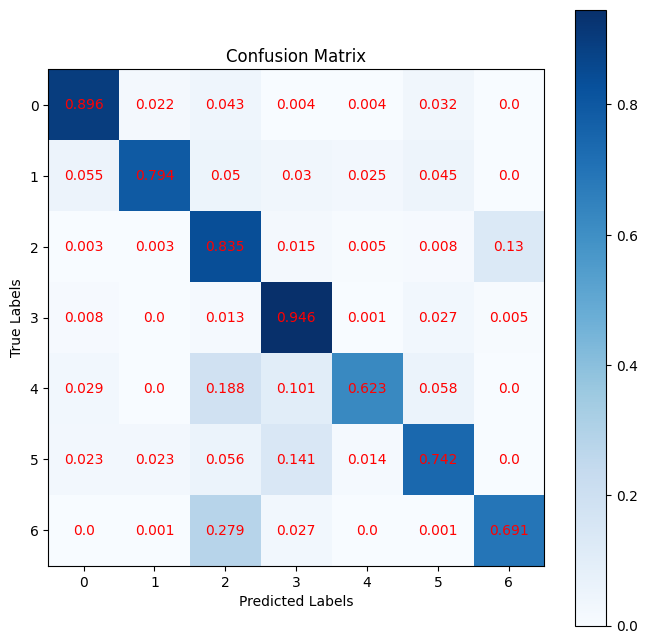

In [ ]:
# Get predictions on the test set
y_pred_probs = classifier_model.predict(test_dataset_final)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_dataset_final], axis=0)  # Assumes (x, y) in dataset

# Optional: Normalize the confusion matrix
cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

cm_normalized_short= np.around(cm_normalized.astype('float') / cm_normalized.sum(axis=1)[:, np.newaxis], decimals=3)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.colorbar()

# Add labels to each cell
for i in range(cm_normalized_short.shape[0]):
    for j in range(cm_normalized_short.shape[1]):
        plt.text(j, i, cm_normalized_short[i, j], ha='center', va='center', color='red')

plt.show()

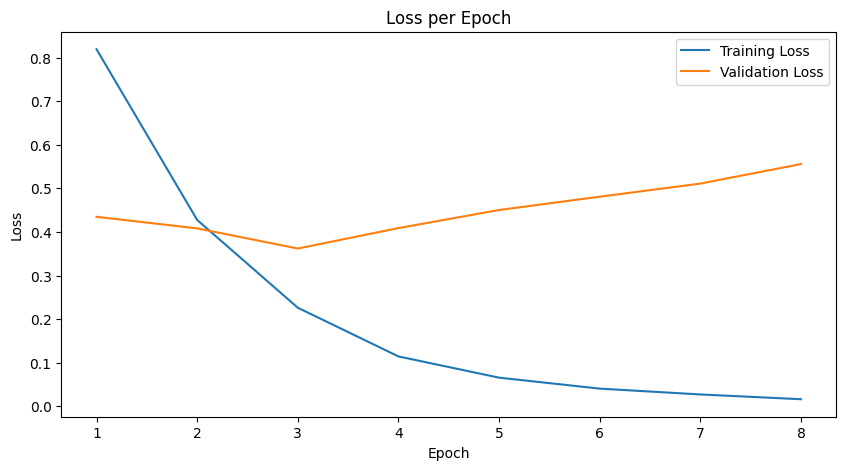

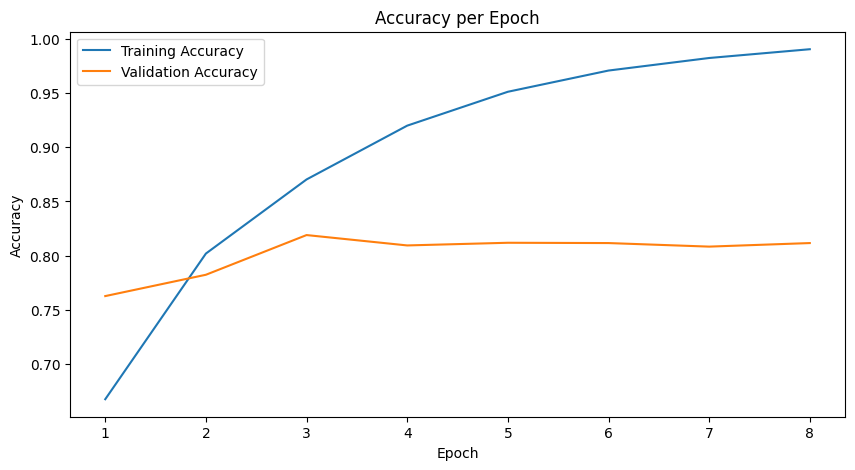

In [41]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["sparse_categorical_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 5: Save & Test the model

In [ ]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{"model"}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)
preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)
model_for_export.save(saved_model_path, include_optimizer=True)

In [ ]:

rawtext_test = ["tomorrow danish will give some presentation, he feel so nervous, what if he mules"]
predictions = model_load_test.predict(rawtext_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(classes)
print(tf.nn.softmax(predictions))

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {classes[predicted_class_index]}")